## Part 4: Model Training Worflow

This notebook describes the overall workflow from preparing dataset, the selection of model, train and validation process on few datapoints.

In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import random
import satlaspretrain_models
import matplotlib.pyplot as plt
import rasterio as rio

import torch.optim as optim
import torch.nn.functional as F

from scipy import ndimage

##### 1. Split Dataset

We are aware that the location of a fire event may be dependent on its surroundings. However, we start to treat each fire event as an independent sample when training the model.

In [7]:
data_folder = f"../data_example"
img_dir = f'{data_folder}/post_fire'
mask_dir = f'{data_folder}/masks'

In [8]:
def split_dataset(img_dir, train_ratio = 0.8, val_ratio = 0.1, test_ratio = 0.1, seed = 0):
    """Split the dataset into train, validation and test according to ratio"""
    data = os.listdir(img_dir)
    data_size = len(data)

    train_size = int(data_size * train_ratio)
    val_size = int(data_size * val_ratio)
    test_size = int(data_size * test_ratio)
    print(f"Training data size {train_size}, Validation data size {val_size}, Testing data size {test_size}")

    # Shuffle all images and split into three subsets
    random.seed(seed)
    random.shuffle(data)
    train_data = data[:train_size]
    val_data = data[train_size : train_size+val_size]
    test_data = data[train_size+val_size : data_size]

    return train_data, val_data, test_data

In [9]:
train_data, val_data, test_data = split_dataset(img_dir=img_dir)

Training data size 16, Validation data size 2, Testing data size 2


In [ ]:
class FireDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_list, transforms):
        super().__init__()
        self.img_dir = img_dir
        self.mask_dir = mask_dir   # 0, 1 unburned or burned
        self.img_list = img_list
        self.transforms = transforms

    def __len__(self):
        return len(self.img_list)

    def fill_norm(self, data):
        
        filled_data = np.zeros_like(data)

        for idx in range(data.shape[0]):
            band = data[idx,:, :].copy()   # 2d
            
            mask = np.isnan(band)  # True is nan
            if np.any(mask):
                # Replace nan with nearest non-nan values
                indices = ndimage.distance_transform_edt(mask, return_distances=False, return_indices=True)
                band = band[tuple(indices)]

            norm_band = np.zeros_like(band)
            if idx < 3:
                # Perform normalization for RGB -- divided by 255
                norm_band = (band / 255.0).clip(0.0, 1.0)
            else:
                norm_band = (band / 8160.0).clip(0.0, 1.0)

            filled_data[idx] = norm_band   

        return filled_data

    def __getitem__(self, idx):
        file_name = self.img_list[idx]

        img_path = os.path.join(self.img_dir, file_name)
        mask_path = os.path.join(self.mask_dir, file_name)

        with rio.open(img_path) as img:
            img_data = img.read().astype(np.float32)
            img_data[img_data == img.nodata] = np.nan
            img_data = self.fill_norm(img_data)
        with rio.open(mask_path) as mask:
            mask_data = mask.read()

        img_tensor = self.mapping(img_data)
        mask_tensor = torch.from_numpy(mask_data).long().squeeze()

        if self.transforms:
            img_tensor = self.transforms(img_tensor)
            mask_tensor = self.transforms(mask_tensor)

        return img_tensor, mask_tensor

    def mapping(self, data):
        # Prepare image tensor with shape (9, H, W) for Satlas multi-band model
        # Satlas (multi-band) expects [TCI_R, TCI_G, TCI_B, B05, B06, B07, B08, B11, B12]
        # Band order that I saved: [TCI_R, TCI_G, TCI_B, B8, B12]
        H, W = data.shape[1], data.shape[2]
        out = np.zeros((9, H, W), dtype=np.float32)

        TCI_R, TCI_G, TCI_B, B8, B12 = data
        out[0] = TCI_R  # Red
        out[1] = TCI_G  # Green
        out[2] = TCI_B  # Blue
        out[6] = B8  # NIR
        out[8] = B12 # SWIR

        return torch.from_numpy(out).float()

In [36]:
## Create dataloader
transform = transforms.Compose([
            transforms.RandomCrop(224, padding=4),
            ])

train_dataset = FireDataset(img_dir=img_dir, mask_dir=mask_dir, img_list=train_data, transforms=transform)
val_dataset = FireDataset(img_dir=img_dir, mask_dir=mask_dir, img_list=val_data, transforms=transform)
test_dataset = FireDataset(img_dir=img_dir, mask_dir=mask_dir, img_list=test_data, transforms=None)

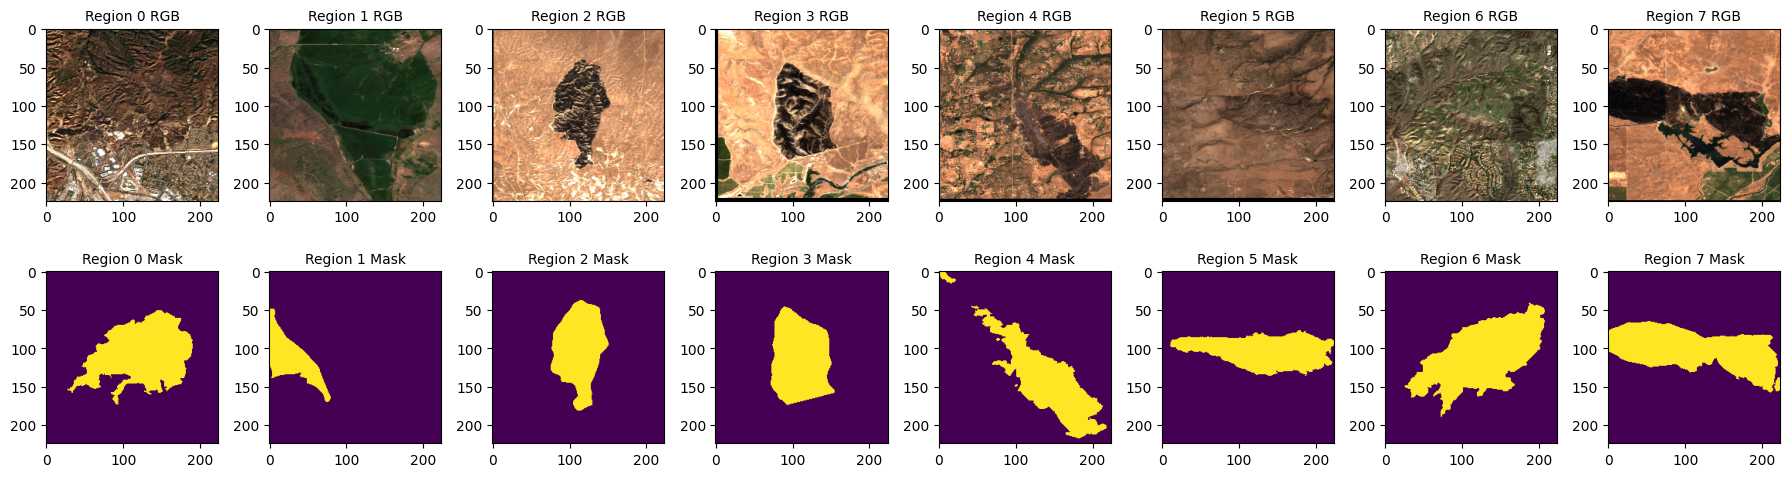

In [39]:
# Visualize few samples
fig, ax = plt.subplots(2, 8, figsize=(18, 5))
for i in range(8):
    data, target = train_dataset[i]

    image = data.numpy()
    target = target.numpy()

    rgb = image[:3]
    rgb = np.rollaxis(rgb, 0, rgb.ndim)  # (C, H, W) -> (H, W, C)
    ax[0, i].imshow(rgb)
    ax[0, i].set_title(f"Region {i} RGB", fontsize=10)
    ax[1, i].imshow(target)
    ax[1, i].set_title(f"Region {i} Mask", fontsize=10)

plt.tight_layout()
plt.show()

In [41]:
batch_size = 10
num_workers = 0

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#### Load a pre-trained model from remote sensing foundation models
https://pypi.org/project/satlaspretrain-models/

https://github.com/allenai/satlaspretrain_models/blob/main/demo.ipynb

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize a Weights instance to specify the pretrained model
weights_manager = satlaspretrain_models.Weights()

# The pretrained model that I used here is from remote sensing foundation models, which is pretrained on Sentinel-2
# Choose segmentation head for binary classes
# Load backbone + FPN
model = weights_manager.get_pretrained_model(model_identifier="Sentinel2_SwinB_SI_MS",
                                             fpn=True,
                                             num_categories=2,
                                             head=satlaspretrain_models.Head.SEGMENT,
                                             device=device).to(device)

In [ ]:
# Check the model architecture
# https://github.com/allenai/satlas/blob/main/ModelArchitecture.md
# model

for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)

#### Setup training process



source: https://blog.paperspace.com/image-segmentation-using-segmentation_models_pytorch/

In [43]:
lr = 1e-4
epochs = 10

optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [44]:
# https://medium.com/data-scientists-diary/implementation-of-dice-loss-vision-pytorch-7eef1e438f68

def dice_loss(outputs, targets):
    num_classes=2
    probs = F.softmax(outputs[0], dim=1)  # Compute prob across number of classes

    # Resize output to match target:
    if probs.shape[2:] != targets.shape[1:]:
        probs = F.interpolate(probs, size=targets.shape[1:], mode='bilinear', align_corners=False)

    # One-hot encoding with tensor shape (N, C, H, W)
    targets_one_hot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float().to(targets.device)


    dims = (0, 2, 3)
    epsilon = 1e-6
    # Compute dice for fire area and background
    intersection = torch.sum(probs * targets_one_hot, dim=dims)
    cardinality = torch.sum(probs + targets_one_hot, dim=dims)
    union = cardinality - intersection
    dice_per_class = (2. * intersection + epsilon) / (cardinality + epsilon)
    iou_per_class = (intersection + epsilon) / (union + epsilon)

    # Handle imbalanced classes
    class_counts = torch.sum(targets_one_hot, dim=dims)
    class_weights = 1.0 / (class_counts + epsilon)
    class_weights = class_weights / class_weights.sum()
    weights = torch.tensor(class_weights, device=targets.device)

    # Weighted dice
    weighted_dice = torch.sum(dice_per_class * weights)
    weighted_iou = torch.sum(iou_per_class * weights) / weights.sum()

    # return dice loss
    return 1.0 - weighted_dice, weighted_dice, weighted_iou

In [45]:
def train(model, train_dataloader, optimizer, criterion, device):
    model.train()
    sum_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss, _, _ = criterion(outputs, targets)
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()

    average_loss = sum_loss / len(train_dataloader)
    return average_loss

In [46]:
def validate(model, val_dataloader, criterion, device):
    model.eval()
    sum_loss = 0
    sum_dice = 0
    sum_iou = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss, dice_score, iou = criterion(outputs, targets)
            sum_loss += loss.item()
            sum_dice += dice_score.item()
            sum_iou += iou.item()

    average_loss = sum_loss / len(val_dataloader)
    average_dice = sum_dice / len(val_dataloader)
    average_iou = sum_iou / len(val_dataloader)
    return average_loss, average_dice, average_iou


In [47]:
def run(model, epochs, train_dataloader, val_dataloader, optimizer, criterion, scheduler, device):
    for epoch in range(1, epochs + 1):
        train_loss = train(model,
                           train_dataloader=train_dataloader,
                           optimizer=optimizer,
                           criterion=criterion,
                           device=device,)
        val_loss, val_dice, val_iou = validate(model,
                            val_dataloader=val_dataloader,
                            criterion=criterion,
                            device=device,)
        scheduler.step()
        print(f"Epoch [{epoch}/{epochs}]: train loss {train_loss} | val loss {val_loss} | val dice {val_dice} | val iou {val_iou}")

In [ ]:
run(model, epochs, train_dataloader, val_dataloader, optimizer, dice_loss, scheduler, device)

C:\Users\drn20\AppData\Local\Temp\ipykernel_8456\447542371.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(class_weights, device=targets.device)


In [ ]:
model.eval()
with torch.no_grad():
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs[0], dim=1)

In [ ]:
print(f"Inputs shape {inputs.shape}")  # num_samples, channels, height, width
print(f"First sample input shape {inputs[0].shape}")
print(f"First sample RGB channel {inputs[0][:3].shape}")
print(f"Predictions shape {preds.shape}")

Inputs shape torch.Size([10, 9, 224, 224])
First sample input shape torch.Size([9, 224, 224])
First sample RGB channel torch.Size([3, 224, 224])
Predictions shape torch.Size([10, 224, 224])


NameError: name 'inputs' is not defined

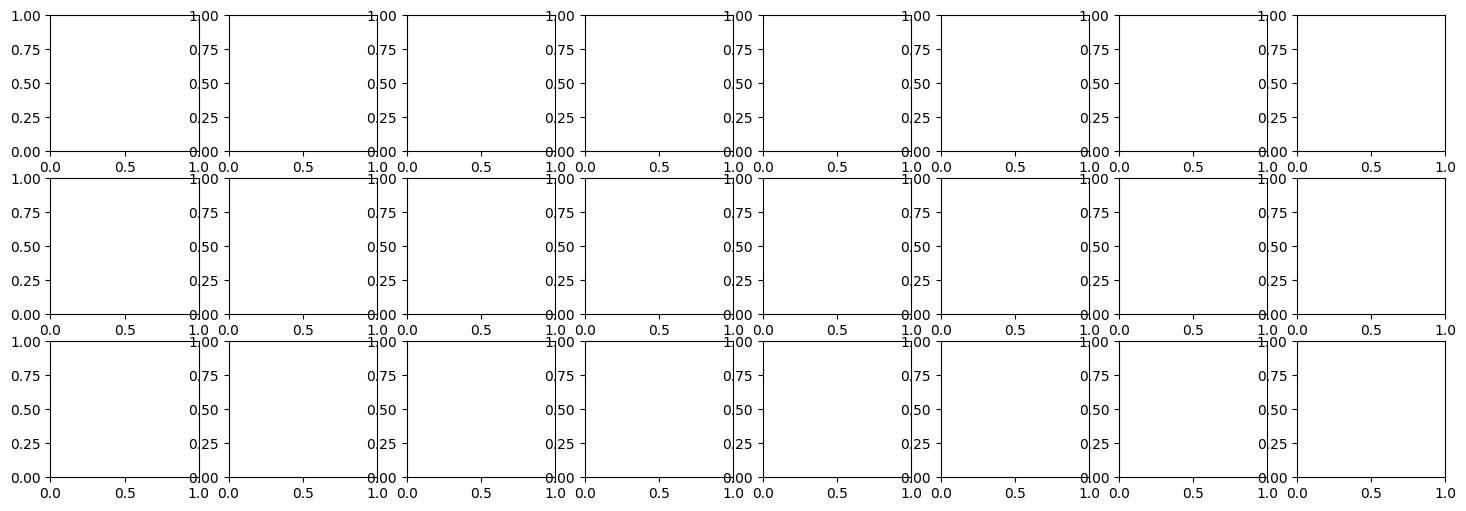

In [ ]:
num_samples = 8
fig, ax = plt.subplots(3, num_samples, figsize=(18, 6))
for i in range(num_samples):
    img = inputs[i].cpu()
    rgb = img[:3]
    rgb = rgb.permute(1, 2, 0).numpy()

    ground_truth = targets[i].cpu().numpy()
    prediction = preds[i].detach().cpu().numpy()
    ax[0, i].imshow(rgb)
    ax[0, i].set_title(f"Region {i}")

    ax[1, i].imshow(ground_truth)
    ax[1, i].set_title(f"Region {i} Ground Truth")

    ax[2, i].imshow(prediction)
    ax[2, i].set_title(f"Region {i} Prediction")

plt.tight_layout()
plt.show()